
Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('btc2019.csv')
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj.Close,Volume,lagClose,closeDiff
0,2,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN
1,3,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,3843.520020,99.889404
2,4,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,3943.409424,-106.668213
3,5,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,3836.741211,20.976318
4,6,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,3857.717529,-12.522949


In [2]:
df.drop(df.columns[[0]], axis = 1, inplace = True)
df.head()

,Date,Open,High,Low,Close,Adj.Close,Volume,lagClose,closeDiff
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,3843.520020,99.889404
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,3943.409424,-106.668213
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,3836.741211,20.976318
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,3857.717529,-12.522949


In [3]:
# Unix-time to 
df.Date = pd.to_datetime(df.Date)

# Resampling to daily frequency
df.index = df.Date
df = df.resample('D').mean()
df.head()

,Open,High,Low,Close,Adj.Close,Volume,lagClose,closeDiff
Date,,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09,NaN,NaN
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09,3843.520020,99.889404
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09,3943.409424,-106.668213
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09,3836.741211,20.976318
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09,3857.717529,-12.522949


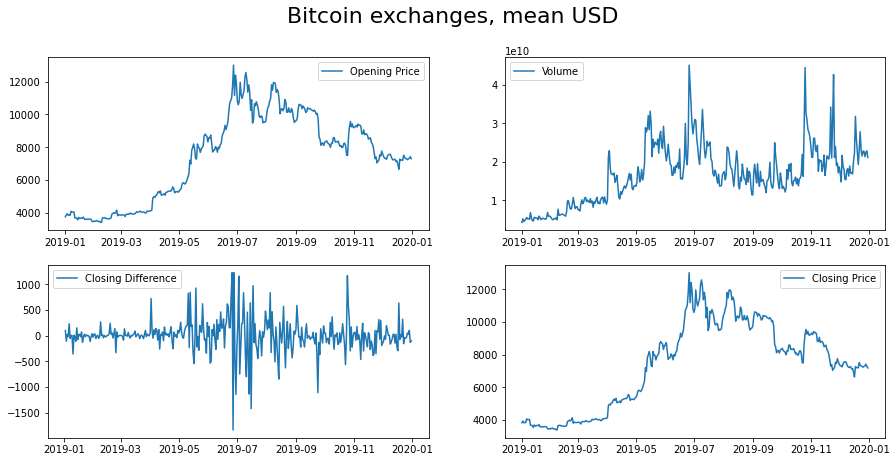

In [4]:
import matplotlib.pyplot as plt

# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Open, '-', label='Opening Price')
plt.legend()

plt.subplot(222)
plt.plot(df.Volume, '-', label='Volume')
plt.legend()

plt.subplot(223)
plt.plot(df.closeDiff, '-', label='Closing Difference')
plt.legend()

plt.subplot(224)
plt.plot(df.Close, '-', label='Closing Price')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.513404


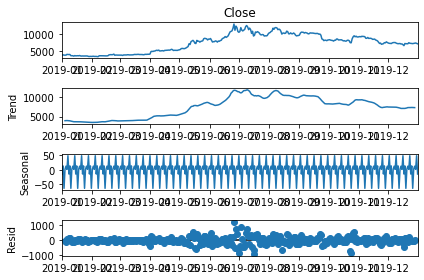

In [5]:
#seasonal_decompose and check for stationarity of Close Price
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

seasonal_decompose(df.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df.Close)[1])
plt.show()

0.840315158361666
Dickey–Fuller test: p=0.535885


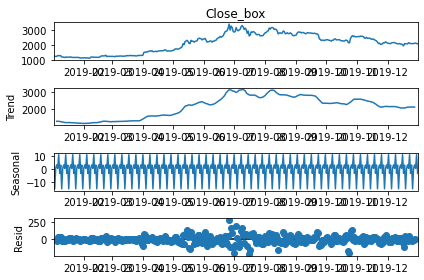

In [6]:
from scipy import stats
df['Close_box'], lmbda = stats.boxcox(df.Close)
print(lmbda)

seasonal_decompose(df.Close_box[1:]).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df.Close_box[1:])[1])
plt.show()

In [7]:
df_train = df.iloc[0:305]

Implementing SARIMAX - Univariate 

In [8]:
# Initial approximation of parameters

from itertools import product
import warnings
warnings.simplefilter('ignore')
import statsmodels.api as sm


Qs = range(0, 2)
qs = range(0, 2)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
# print(parameters_list)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_train.Close_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    # print(aic)
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [9]:
# Checking for the best model parameters combination 

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

      parameters          aic
3   (0, 0, 1, 1)  3411.094707
9   (0, 1, 1, 1)  3412.273964
15  (1, 0, 1, 1)  3412.354132
5   (0, 0, 2, 1)  3412.395605
1   (0, 0, 0, 1)  3412.743938
                                      SARIMAX Results                                       
Dep. Variable:                            Close_box   No. Observations:                  305
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1702.547
Date:                              Wed, 27 Apr 2022   AIC                           3411.095
Time:                                      14:23:15   BIC                           3422.125
Sample:                                  01-01-2019   HQIC                          3415.513
                                       - 11-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

In [10]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

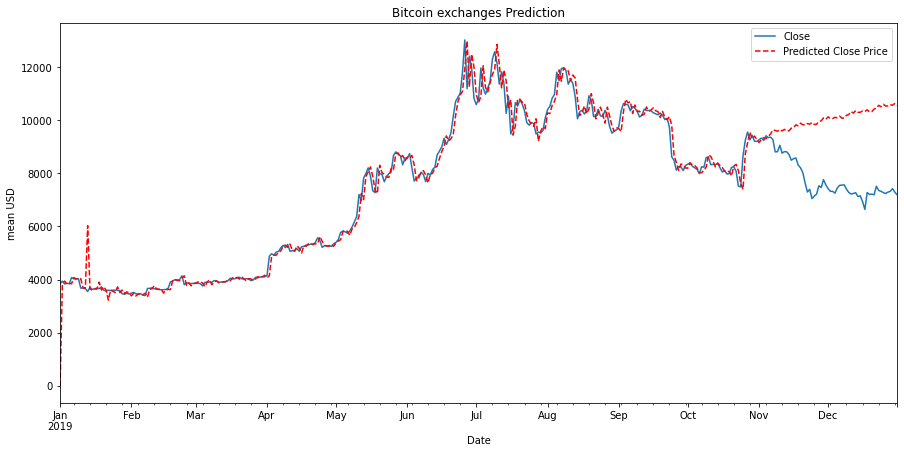

In [11]:
from datetime import datetime, timedelta
df_predicts = df[['Close']]


df_predicts['forecast'] = invboxcox(best_model.predict(start=0, end= 365),lmbda)

plt.figure(figsize=(15,7))
df_predicts.Close.plot()
df_predicts.forecast.plot(color='r', ls='--', label='Predicted Close Price')
plt.legend()
plt.title('Bitcoin exchanges Prediction')
plt.ylabel('mean USD')
plt.show()

In [12]:
y_forecasted = df_predicts.forecast
y_truth = df_predicts.Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Root Mean Squared Error: {}'.format(round(rmse, 2)))

# Compute the root mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean Squared Error: {}'.format(round(mse, 2)))

#Compute MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape_val = mape(y_truth,y_forecasted)
print('Mean Average Persentage Error: {}'.format(round(mape_val, 2)))

Root Mean Squared Error: 1081.64
Mean Squared Error: 1169953.05
Mean Average Persentage Error: 7.61


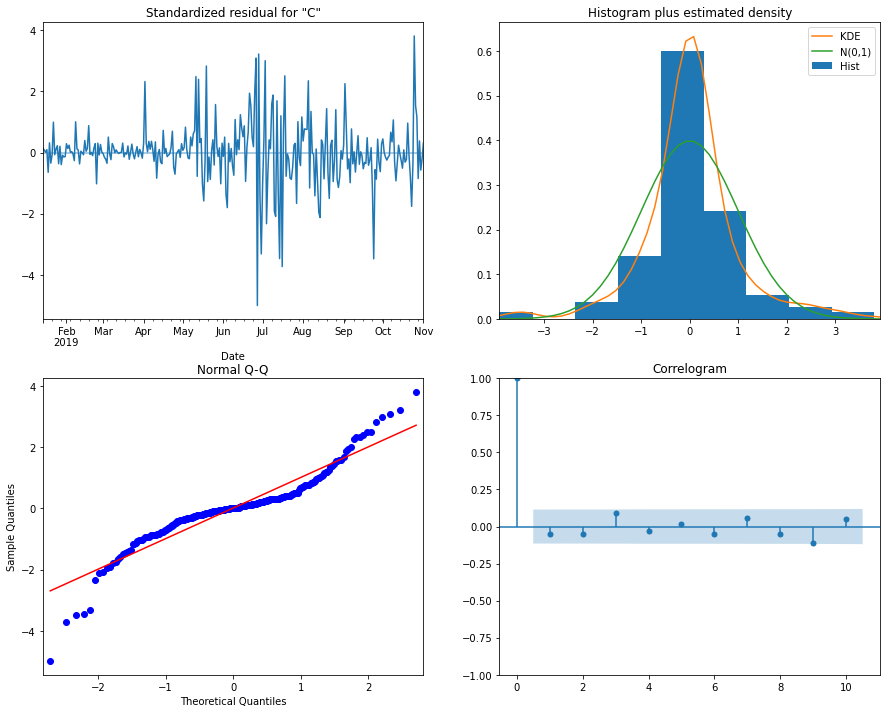

In [13]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Implementing SARIMAX considering the Sentiment Score 

In [14]:
df = pd.read_csv('Vader_op_final.csv')
df.head()

,Unnamed: 0,datetime,date,author,subreddit,created_utc,score,controversiality,body,answer,...,High,Low,Close,Adj.Close,Volume,lagClose,closeDiff,scores_vader,compound,comp_score
0,0,2019-11-07 00:00:33,2019-11-07,bstheory,AskReddit,1573084833,78,0,SS Giving up too easily trying to buy bitcoin ...,SS Giving easily trying buy bitcoin 30,...,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compou...",0.5859,pos
1,1,2019-11-07 04:28:42,2019-11-07,superfudging,business,1573100922,66,0,That is the most obvious and original thought ...,That obvious original thought Bitcoin I heard,...,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",0.3182,pos
2,2,2019-11-07 11:08:58,2019-11-07,aminechbani2,Gamingcirclejerk,1573124938,26,0,Along with Bitcoin in general,Along Bitcoin general,...,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
3,3,2019-11-07 16:31:32,2019-11-07,swiss-BTC,google,1573144292,16,0,I tried to use a bitcoin wallet address as wel...,I tried use bitcoin wallet address well Guess ...,...,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",0.2732,pos
4,4,2019-11-07 06:27:56,2019-11-07,zephyrsong888,technology,1573108076,19,0,Maybe they need to break facebook up by not co...,Maybe need break facebook connecting piece tog...,...,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.069, 'neu': 0.887, 'pos': 0.044, 'co...",-0.1027,neg


In [15]:
df.drop(df.columns[[0]], axis = 1, inplace = True)
df.head()

,datetime,date,author,subreddit,created_utc,score,controversiality,body,answer,Open,High,Low,Close,Adj.Close,Volume,lagClose,closeDiff,scores_vader,compound,comp_score
0,2019-11-07 00:00:33,2019-11-07,bstheory,AskReddit,1573084833,78,0,SS Giving up too easily trying to buy bitcoin ...,SS Giving easily trying buy bitcoin 30,9352.393555,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compou...",0.5859,pos
1,2019-11-07 04:28:42,2019-11-07,superfudging,business,1573100922,66,0,That is the most obvious and original thought ...,That obvious original thought Bitcoin I heard,9352.393555,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",0.3182,pos
2,2019-11-07 11:08:58,2019-11-07,aminechbani2,Gamingcirclejerk,1573124938,26,0,Along with Bitcoin in general,Along Bitcoin general,9352.393555,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
3,2019-11-07 16:31:32,2019-11-07,swiss-BTC,google,1573144292,16,0,I tried to use a bitcoin wallet address as wel...,I tried use bitcoin wallet address well Guess ...,9352.393555,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",0.2732,pos
4,2019-11-07 06:27:56,2019-11-07,zephyrsong888,technology,1573108076,19,0,Maybe they need to break facebook up by not co...,Maybe need break facebook connecting piece tog...,9352.393555,9368.476563,9202.353516,9267.561523,9267.561523,22700383839,9360.879883,-93.31836,"{'neg': 0.069, 'neu': 0.887, 'pos': 0.044, 'co...",-0.1027,neg


In [16]:
# Unix-time to 
df.Date = pd.to_datetime(df.datetime)

# Resampling to daily frequency
df.index = df.Date
df = df.resample('D').mean()
df.head()

,created_utc,score,controversiality,Open,High,Low,Close,Adj.Close,Volume,lagClose,closeDiff,compound
datetime,,,,,,,,,,,,
2019-01-01,1.546349e+09,4.170678,0.032823,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09,NaN,NaN,0.281567
2019-01-02,1.546435e+09,4.300077,0.045630,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09,3843.520020,99.889404,0.266894
2019-01-03,1.546522e+09,6.055873,0.060317,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09,3943.409424,-106.668213,0.246672
2019-01-04,1.546605e+09,7.009467,0.057988,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09,3836.741211,20.976318,0.248096
2019-01-05,1.546697e+09,4.468270,0.062124,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09,3857.717529,-12.522949,0.239250


0.840315158361666
Dickey–Fuller test: p=0.535885


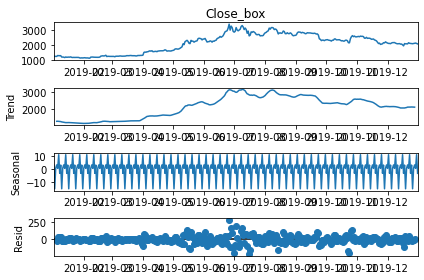

In [17]:
from scipy import stats
df['Close_box'], lmbda = stats.boxcox(df.Close)
print(lmbda)

seasonal_decompose(df.Close_box[1:]).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df.Close_box[1:])[1])
plt.show()

In [18]:
df_train = df.iloc[0:305]

In [19]:
## defining the external factors ##

exog1=df_train['compound']

In [20]:
df_test = df.iloc[304:365]
exog2=df_test['compound']

In [21]:
# Initial approximation of parameters

from itertools import product
import warnings
warnings.simplefilter('ignore')
import statsmodels.api as sm


Qs = range(0, 2)
qs = range(0, 2)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
# print(parameters_list)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_train.Close_box,exog=exog1, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    # print(aic)
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [22]:
# Checking for the best model parameters combination 

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

      parameters          aic
3   (0, 0, 1, 1)  3412.937224
9   (0, 1, 1, 1)  3414.147006
5   (0, 0, 2, 1)  3414.209169
15  (1, 0, 1, 1)  3414.224363
1   (0, 0, 0, 1)  3414.603431
                                      SARIMAX Results                                       
Dep. Variable:                            Close_box   No. Observations:                  305
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1702.469
Date:                              Wed, 27 Apr 2022   AIC                           3412.937
Time:                                      14:25:07   BIC                           3427.644
Sample:                                  01-01-2019   HQIC                          3418.828
                                       - 11-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

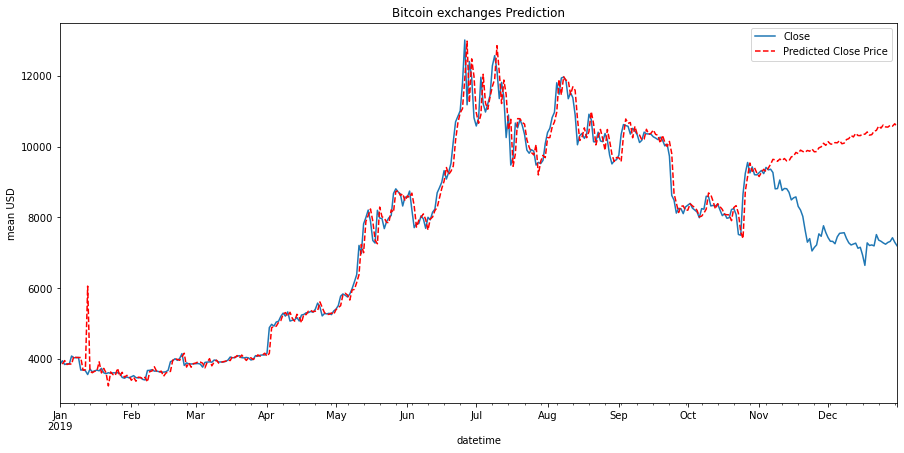

In [23]:
from datetime import datetime, timedelta
df_predicts = df[['Close']]


df_predicts['forecast'] = invboxcox(best_model.predict(start=0, end= 365, exog = exog2),lmbda)

plt.figure(figsize=(15,7))
df_predicts.Close.plot()
df_predicts.forecast.plot(color='r', ls='--', label='Predicted Close Price')
plt.legend()
plt.title('Bitcoin exchanges Prediction')
plt.ylabel('mean USD')
plt.show()

Analysing the Results

In [24]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[1:])[1])

Dickey–Fuller test:: p=0.000000


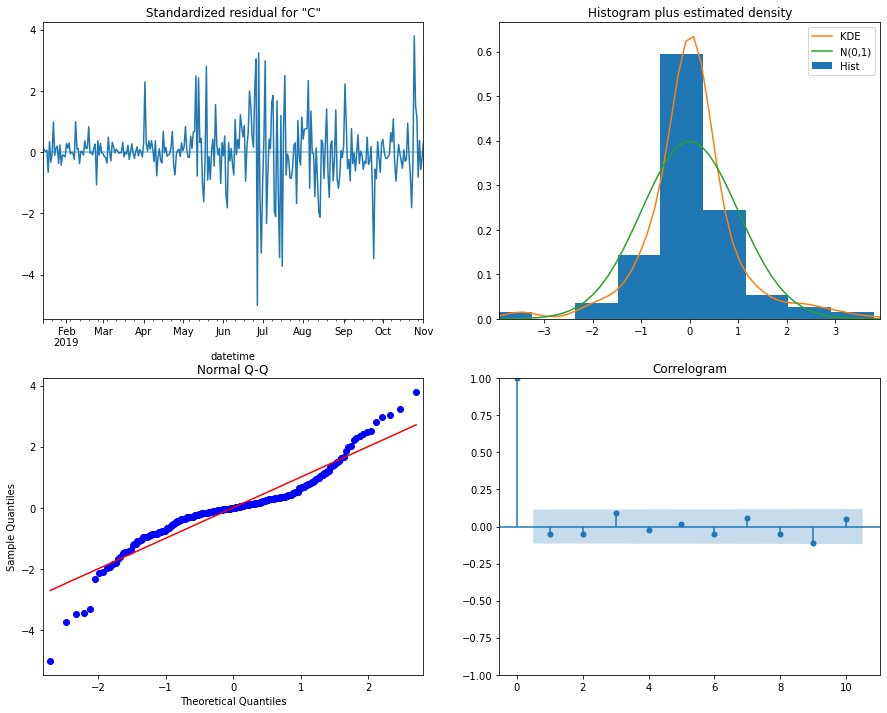

In [25]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [26]:
y_forecasted = df_predicts.forecast
y_truth = df_predicts.Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Root Mean Squared Error: {}'.format(round(rmse, 2)))

# Compute the root mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean Squared Error: {}'.format(round(mse, 2)))

#Compute MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.nanmean(np.abs((actual - pred) / actual)) * 100

mape_val = mape(y_truth,y_forecasted)
print('Mean Average Persentage Error: {}'.format(round(mape_val, 2)))

Root Mean Squared Error: 1069.97
Mean Squared Error: 1144832.26
Mean Average Persentage Error: 7.39
